In [1]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
import time
import pickle
from fuzzywuzzy import fuzz
from collections import defaultdict
import stanza
import inflect
from matplotlib import pyplot as plt
from matplotlib import image as mpimg


In [2]:
stanza.download('en')

2020-12-06 20:51:09 INFO: Downloading default packages for language: en (English)...
2020-12-06 20:51:10 INFO: File exists: C:\Users\Raghav\stanza_resources\en\default.zip.
2020-12-06 20:51:14 INFO: Finished downloading models and saved to C:\Users\Raghav\stanza_resources.


In [3]:
nlp = stanza.Pipeline()

2020-12-06 20:51:14 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| sentiment | sstplus   |
| ner       | ontonotes |

2020-12-06 20:51:14 INFO: Use device: gpu
2020-12-06 20:51:14 INFO: Loading: tokenize
2020-12-06 20:51:16 INFO: Loading: pos
2020-12-06 20:51:17 INFO: Loading: lemma
2020-12-06 20:51:17 INFO: Loading: depparse
2020-12-06 20:51:18 INFO: Loading: sentiment
2020-12-06 20:51:19 INFO: Loading: ner
2020-12-06 20:51:20 INFO: Done loading processors!


In [4]:
inflector = inflect.engine()


In [5]:
model = pickle.load(open('q_type_clf2.model','rb'))

In [6]:
doc = nlp("What is your name, bro?")

In [7]:
def return_pos_tags(nlp_object):
    return ([word.xpos for sent in nlp_object.sentences for word in sent.words])

In [8]:
print(return_pos_tags(doc))

['WP', 'VBZ', 'PRP$', 'NN', ',', 'UH', '.']


In [9]:
def return_dep_tags(nlp_object):
    return [word.deprel for sent in nlp_object.sentences for word in sent.words]

In [10]:
def return_tokens(nlp_object):
    return [word.text for sent in nlp_object.sentences for word in sent.words]

In [11]:
def extract_intention(sentence):
    doc = nlp(sentence)
    nouns = []
    pos = return_pos_tags(doc)
    parse = return_dep_tags(doc)
    text = return_tokens(doc)
    for i in range(len(pos)):
        if pos[i][:2] == 'NN':
            nouns.append((text[i],parse[i]))
    subj = inflector.singular_noun(nouns[0][0])
    if not subj:
        subj = nouns[0][0]
    if len(nouns) > 1:
        for i in range(len(nouns)):
            if nouns[i][1] == 'nsubj':
                subj = inflector.singular_noun(nouns[i][0])
                if not subj:
                    subj = nouns[i][0]
    obj = [word for (word, tag) in nouns if word != subj]
    return model.predict([sentence])[0], subj, obj

In [12]:
extract_intention('How many people are there?')

('other', 'person', ['people'])

In [13]:
confThreshold = 0.4  
nmsThreshold = 0.4   
inpWidth = 960       
inpHeight = 960      
classesFile = "names.txt"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
modelConfiguration = "yolo-obj.cfg"
modelWeights = "yolov4.weights"

In [14]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [15]:
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    items.append(label)
    
    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

In [16]:
def postprocess(frame, outs):
    print(len(outs))
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)
        locations.append((left + width // 2, top + height // 2))

In [17]:
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_OPENCL)

In [98]:
cap = cv.VideoCapture('veggies.jpg')
hasFrame, frame = cap.read()
blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
net.setInput(blob)
outs = net.forward(getOutputsNames(net))

In [84]:
inpWidth, inpHeight

(960, 960)

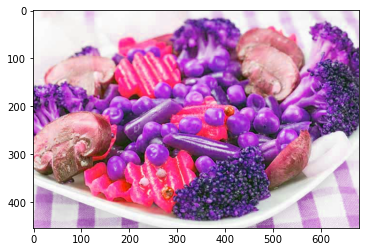

In [99]:
plt.imshow(np.roll(frame,1,axis=2))


In [100]:
items = []
locations = []
postprocess(frame, outs)
#final_items = defaultdict(int)
final_items = defaultdict(lambda: {})

for a, b in zip(items, locations):
    temp = a.split(":")[0]
    if "count" not in final_items[temp]:
        final_items[temp]["count"] = 0
    final_items[temp]["count"] += 1
    if "location" not in final_items[temp]:
        final_items[temp]["location"] = []
    final_items[temp]["location"].append(b)
final_items[temp]['location'].sort()

3


In [101]:
for item in final_items:
    print("There are", final_items[item], "of the object:", item)

There are {'count': 3, 'location': [(395, 357), (595, 185), (359, 67)]} of the object: broccoli
There are {'count': 1, 'location': [(129, 340)]} of the object: carrot


In [76]:
def how_many(subj,d,is_there=False):
    if 'count' not in d[subj]:
        if is_there:
            return 'No'
        return 0
    count = d[subj]['count']
    if is_there and count:
        return 'Yes'
    elif is_there and not count:
        return 'No'
    return count

def is_there(subj,d):
    return how_many(subj,d,True)

def what_is(d):
    objects = [k for k in d.keys()]
    return objects

def where(subj,d):
    locs = []
    
    for x,y in d[subj]['location']:
   
        loc = ''
     
        loc += "Vertical: "
        if y <= 120:
            loc += 'top'
        elif y > 800:
            loc += 'bottom'
        else:
            loc += 'middle'

        loc += ", Horizontal:"
        if x <= 120:
            loc += ' left'
        elif x > 600:
            loc += ' right'
        else:
            loc += ' middle'
        locs.append(loc)
    return locs

def what_color(subj,d):
    img = d[subj]['bbox']
    def _closest_color(requested_color):
        min_colors = {}
        for key, name in webcolors.common_colors:
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - requested_color[0]) ** 2
            gd = (g_c - requested_color[1]) ** 2
            bd = (b_c - requested_color[2]) ** 2
            min_colors[(rd + gd + bd)] = name
        return min_colors[min(min_colors.keys())]
    def _get_color_name(requested_color):
        try:
            closest_name = actual_name = webcolors.rgb_to_name(requested_color)
        except ValueError:
            closest_name = _closest_color(requested_color)
            actual_name = None
        return closest_name
    x,y,c = img.shape
#     plt.imshow(img[x//3:2*x//3,y//3:2*y//3,:])
    r,g,b = [int(np.mean(img[x//3:2*x//3,y//3:2*y//3,i])) for i in range(3)]
    return _get_color_name((r,g,b))

In [103]:
question = "Is there brocolli in this image?"
abc = extract_intention(question)
q, subject, _ = abc
print(abc)
print(subject)

('is this', 'brocolli', ['image'])
brocolli


In [95]:
print(how_many(subject, final_items))

no count
0


In [90]:
intent_to_functions = {}
intent_to_functions['how many'] = how_many 
intent_to_functions['is this'] = is_there
intent_to_functions['what color'] = what_color
intent_to_functions['where'] = where
intent_to_functions['other'] = None

In [102]:

intent_to_functions[q](subject,final_items)

no count


'No'

In [ ]:
fuzz.r